In [127]:
import csv
import numpy as np
import pandas as pd

from keras.models import load_model
from sklearn.externals import joblib

# Load model, best weights and scaler
model = load_model('model.h5')
model.load_weights("weights.hdf5")
scaler = joblib.load("scaler.save")

In [128]:
df = pd.read_csv("poloniex_usdt_btc_20170101_weightedAverage_300.csv", sep=";", index_col=None)

In [129]:
df.tail()

,date,weightedAverage
187724,1539546000,6401.000000
187725,1539546300,6401.000000
187726,1539546600,6401.064122
187727,1539546900,6402.134046
187728,1539547200,6403.722071


In [130]:
dataset_test.head()

,date,weightedAverage
168956,1533915600,6462.811137
168957,1533915900,6467.749930
168958,1533916200,6472.962633
168959,1533916500,6453.055698
168960,1533916800,6450.026590


In [131]:
df_values = df.values
timestamps = df_values[:, 0]
dataset = df_values[:, 1].astype("float")

In [132]:
df.head()

,date,weightedAverage
0,1483228800,964.642624
1,1483229100,965.858035
2,1483229400,963.946565
3,1483229700,962.024978
4,1483230000,963.568648


In [133]:
samples_num = df.shape[0]
test_split = 0.1
dataset_test = df[int(samples_num * (1 - test_split)):]
print(dataset_test.shape)

(18773, 2)


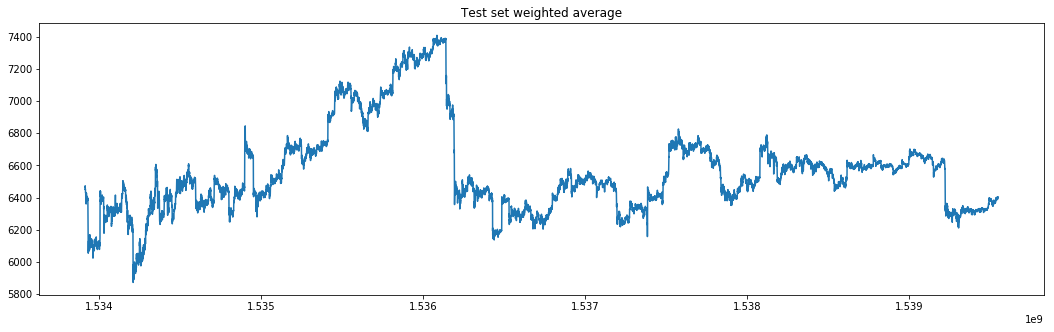

In [134]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(18, 5))
plt.title('Test set weighted average')
plt.plot(dataset_test[['date']], dataset_test[['weightedAverage']])
plt.show()

In [135]:
data = np.array(dataset_test[['weightedAverage']])
data = scaler.transform(data)
print(data[0])
print(data.shape)

[0.27597285]
(18773, 1)


In [136]:
# Predict next 20 candles
prediction_range = 20

predictions = np.zeros(prediction_range)

for interval in range(0,data.shape[0]//prediction_range):
    # Prediction from last 20 candles
    lasts = data[prediction_range*interval:prediction_range*(interval+1)]

    for days in range(prediction_range):
        d = lasts[-prediction_range:].reshape(-1) # Flatten data
        d = np.expand_dims(d, axis=0) # NN waits for array, we use just 1 day as input
        next = model.predict(d, batch_size=1)
        lasts = np.append(lasts, next, axis=0) # Add prediction to known days
        next = next.reshape(1,)[0]
        predictions = np.append(predictions, [next], axis=0)

In [137]:
print(predictions.shape)

(18780,)


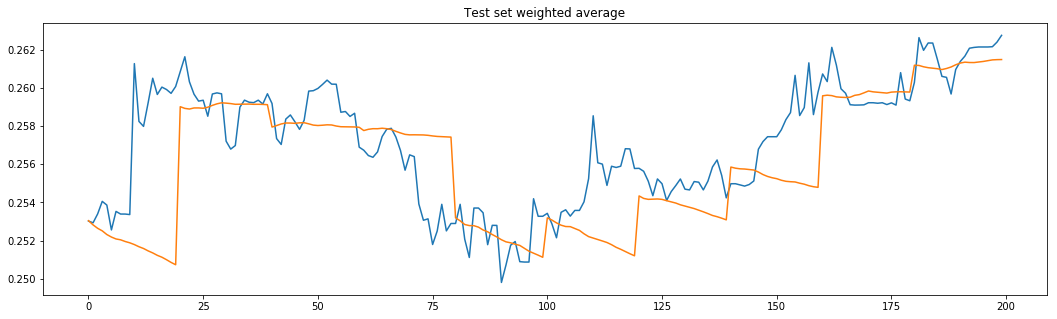

In [140]:
plt.figure(figsize=(18, 5))
plt.title('Test set weighted average')
plt.plot(data[-200:])
plt.plot(predictions[-200:])
plt.show()